In [1]:
# Import required libraries
import os
import zipfile
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models, utils
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize

# For inline plotting in Jupyter Notebook
%matplotlib inline


In [2]:
# Define paths for the ZIP file and extraction folder
zip_path = "BCImages.zip"
extraction_path = "./BCImages"

# Extract the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

print(f"Extracted contents to: {extraction_path}")
print("Extracted folders and files:", os.listdir(extraction_path))

# Inspect the contents of each folder within the extraction directory
for folder in os.listdir(extraction_path):
    folder_path = os.path.join(extraction_path, folder)
    if os.path.isdir(folder_path):
        print(f"Contents of {folder_path}: {os.listdir(folder_path)}")


Extracted contents to: ./BCImages
Extracted folders and files: ['BrandedCharacters_Images']
Contents of ./BCImages/BrandedCharacters_Images: ['ColonelSanders', 'MM', 'CookieGuy', 'NesquickBunny', 'RonaldMcdonald', 'DoughBoy', 'ChesterCheetah', 'TonyTiger', 'MrPeanut', 'KoolAidMan']


In [3]:
# Define paths and split ratios
base_folder = "./BCImages/BrandedCharacters_Images"
output_base_folder = "./SplitDataset"
train_ratio, val_ratio, test_ratio = 0.7, 0.15, 0.15

# Create directories for each split
for split in ['train', 'val', 'test']:
    os.makedirs(os.path.join(output_base_folder, split), exist_ok=True)

# Iterate through each character folder and split images
for character in os.listdir(base_folder):
    character_path = os.path.join(base_folder, character)
    if os.path.isdir(character_path):
        print(f"Processing character: {character}")
        images = [img for img in os.listdir(character_path) if img.lower().endswith(('.jpg', '.jpeg', '.png'))]
        
        # Split images into training and temporary sets, then split temp into val and test
        train_imgs, temp_imgs = train_test_split(images, test_size=(1 - train_ratio), random_state=42)
        val_imgs, test_imgs = train_test_split(temp_imgs, test_size=(test_ratio / (val_ratio + test_ratio)), random_state=42)
        
        # Create subdirectories and copy images to the appropriate folder
        for split, imgs in zip(['train', 'val', 'test'], [train_imgs, val_imgs, test_imgs]):
            split_dir = os.path.join(output_base_folder, split, character)
            os.makedirs(split_dir, exist_ok=True)
            for img in imgs:
                shutil.copy(os.path.join(character_path, img), os.path.join(split_dir, img))
        
        print(f"Finished processing {character}:")
        print(f"  Train: {len(train_imgs)} images")
        print(f"  Validation: {len(val_imgs)} images")
        print(f"  Test: {len(test_imgs)} images")


Processing character: ColonelSanders
Finished processing ColonelSanders:
  Train: 48 images
  Validation: 11 images
  Test: 11 images
Processing character: MM
Finished processing MM:
  Train: 82 images
  Validation: 18 images
  Test: 18 images
Processing character: CookieGuy
Finished processing CookieGuy:
  Train: 86 images
  Validation: 19 images
  Test: 19 images
Processing character: NesquickBunny
Finished processing NesquickBunny:
  Train: 88 images
  Validation: 19 images
  Test: 20 images
Processing character: RonaldMcdonald
Finished processing RonaldMcdonald:
  Train: 116 images
  Validation: 25 images
  Test: 26 images
Processing character: DoughBoy
Finished processing DoughBoy:
  Train: 113 images
  Validation: 24 images
  Test: 25 images
Processing character: ChesterCheetah
Finished processing ChesterCheetah:
  Train: 71 images
  Validation: 15 images
  Test: 16 images
Processing character: TonyTiger
Finished processing TonyTiger:
  Train: 136 images
  Validation: 29 images
 

In [4]:
# Define image transformations for training, validation, and testing
transform = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),  # Data augmentation for training
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ]),
}

data_dir = "./SplitDataset"
image_datasets = {
    'train': datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform['train']),
    'val': datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform['val']),
    'test': datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=transform['test']),
}

batch_size = 32
dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=(x=='train'))
    for x in ['train', 'val', 'test']
}

# Get class names from the training dataset
class_names = image_datasets['train'].classes
print(f"Classes: {class_names}")


Classes: ['ChesterCheetah', 'ColonelSanders', 'CookieGuy', 'DoughBoy', 'KoolAidMan', 'MM', 'MrPeanut', 'NesquickBunny', 'RonaldMcdonald', 'TonyTiger']


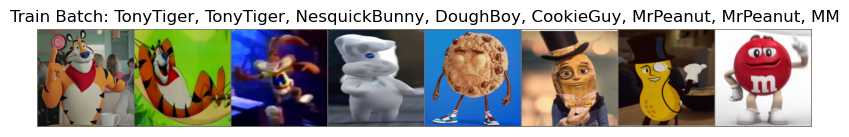

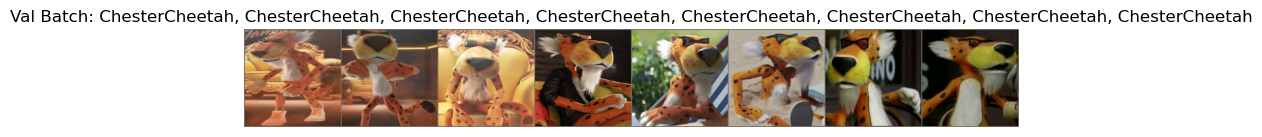

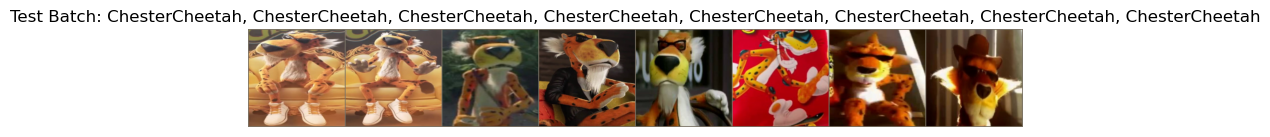

In [5]:
import torchvision

def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean  # Unnormalize
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

# Display a batch from each split (train, val, test)
for split in ['train', 'val', 'test']:
    inputs, labels = next(iter(dataloaders[split]))
    out = utils.make_grid(inputs[:8])
    titles = [class_names[x] for x in labels[:8]]
    plt.figure(figsize=(10, 5))
    plt.title(f"{split.capitalize()} Batch: " + ", ".join(titles))
    imshow(out)


In [6]:
# Load a pre-trained ResNet18 model and modify its final layer
resnet = models.resnet18(pretrained=True)
num_classes = len(class_names)
resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet = resnet.to(device)

# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

num_epochs = 10
best_val_acc = 0.0

# Lists for storing training history (for plotting later)
train_acc_history = []
val_acc_history = []
train_loss_history = []
val_loss_history = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    print('-' * 10)
    
    # Training phase
    resnet.train()
    train_loss = 0.0
    train_correct = 0
    for inputs, labels in dataloaders['train']:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        train_correct += torch.sum(preds == labels.data)
    
    train_loss = train_loss / len(image_datasets['train'])
    train_acc = train_correct.double() / len(image_datasets['train'])
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc.item())
    
    # Validation phase
    resnet.eval()
    val_loss = 0.0
    val_correct = 0
    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = resnet(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += torch.sum(preds == labels.data)
    
    val_loss = val_loss / len(image_datasets['val'])
    val_acc = val_correct.double() / len(image_datasets['val'])
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc.item())
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    # Save the best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(resnet.state_dict(), 'best_resnet_model.pth')
    
    scheduler.step()


/home/sadeeb/miniconda3/envs/cnn_env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sadeeb/miniconda3/envs/cnn_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10
----------
Train Loss: 0.4108, Train Acc: 0.8788
Val Loss: 4.8224, Val Acc: 0.5854
Epoch 2/10
----------
Train Loss: 0.1586, Train Acc: 0.9547
Val Loss: 0.9509, Val Acc: 0.7659
Epoch 3/10
----------
Train Loss: 0.1951, Train Acc: 0.9399
Val Loss: 0.2163, Val Acc: 0.9512
Epoch 4/10
----------
Train Loss: 0.0992, Train Acc: 0.9694
Val Loss: 0.2371, Val Acc: 0.9561
Epoch 5/10
----------
Train Loss: 0.0414, Train Acc: 0.9905
Val Loss: 0.0802, Val Acc: 0.9756
Epoch 6/10
----------
Train Loss: 0.0172, Train Acc: 0.9958
Val Loss: 0.0124, Val Acc: 1.0000
Epoch 7/10
----------
Train Loss: 0.0070, Train Acc: 0.9989
Val Loss: 0.0161, Val Acc: 0.9951
Epoch 8/10
----------
Train Loss: 0.0195, Train Acc: 0.9947
Val Loss: 0.0179, Val Acc: 0.9902
Epoch 9/10
----------
Train Loss: 0.0084, Train Acc: 0.9979
Val Loss: 0.0228, Val Acc: 0.9951
Epoch 10/10
----------
Train Loss: 0.0101, Train Acc: 0.9979
Val Loss: 0.0063, Val Acc: 1.0000


In [7]:
# Load the best model and evaluate on the test set
resnet.load_state_dict(torch.load('best_resnet_model.pth'))
resnet.eval()

test_correct = 0
all_preds = []      # To store predicted labels
all_labels = []     # To store true labels
all_probs = []      # To store output probabilities

# For error analysis (misclassified examples)
incorrect_images = []
incorrect_predictions = []
incorrect_true_labels = []

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = resnet(inputs)
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)
        
        test_correct += torch.sum(preds == labels.data)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.append(probs.cpu().numpy())
        
        # Collect misclassified images for later visualization
        for i in range(inputs.size(0)):
            if preds[i] != labels[i]:
                incorrect_images.append(inputs[i].cpu())
                incorrect_predictions.append(class_names[preds[i]])
                incorrect_true_labels.append(class_names[labels[i]])

test_acc = test_correct.double() / len(image_datasets['test'])
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Total Correct Predictions: {test_correct.item()}")
print(f"Total Incorrect Predictions: {len(all_labels) - test_correct.item()}")

# Concatenate all probability arrays from each batch
all_probs = np.concatenate(all_probs, axis=0)
all_labels_np = np.array(all_labels)


/tmp/ipykernel_70543/2847419498.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet.load_state_dict(torch.load('best_resnet_model.pth'))


Test Accuracy: 0.9763
Total Correct Predictions: 206
Total Incorrect Predictions: 5


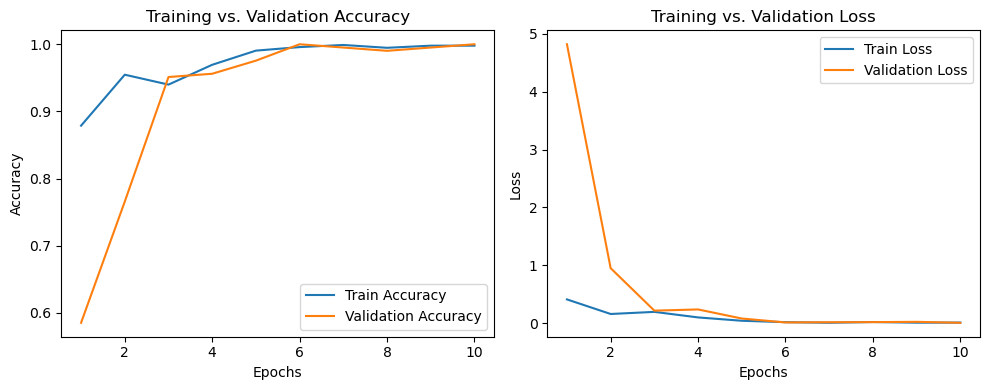

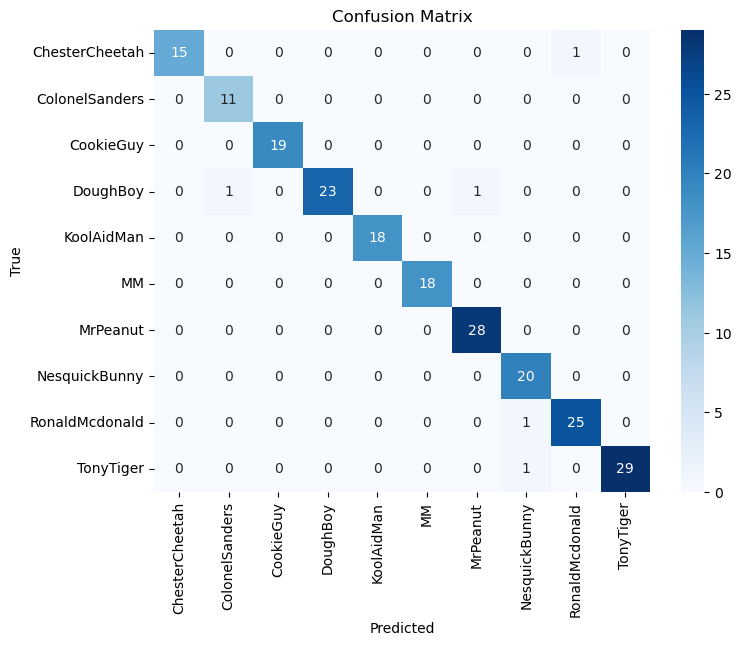

Classification Report:
                precision    recall  f1-score   support

ChesterCheetah       1.00      0.94      0.97        16
ColonelSanders       0.92      1.00      0.96        11
     CookieGuy       1.00      1.00      1.00        19
      DoughBoy       1.00      0.92      0.96        25
    KoolAidMan       1.00      1.00      1.00        18
            MM       1.00      1.00      1.00        18
      MrPeanut       0.97      1.00      0.98        28
 NesquickBunny       0.91      1.00      0.95        20
RonaldMcdonald       0.96      0.96      0.96        26
     TonyTiger       1.00      0.97      0.98        30

      accuracy                           0.98       211
     macro avg       0.98      0.98      0.98       211
  weighted avg       0.98      0.98      0.98       211



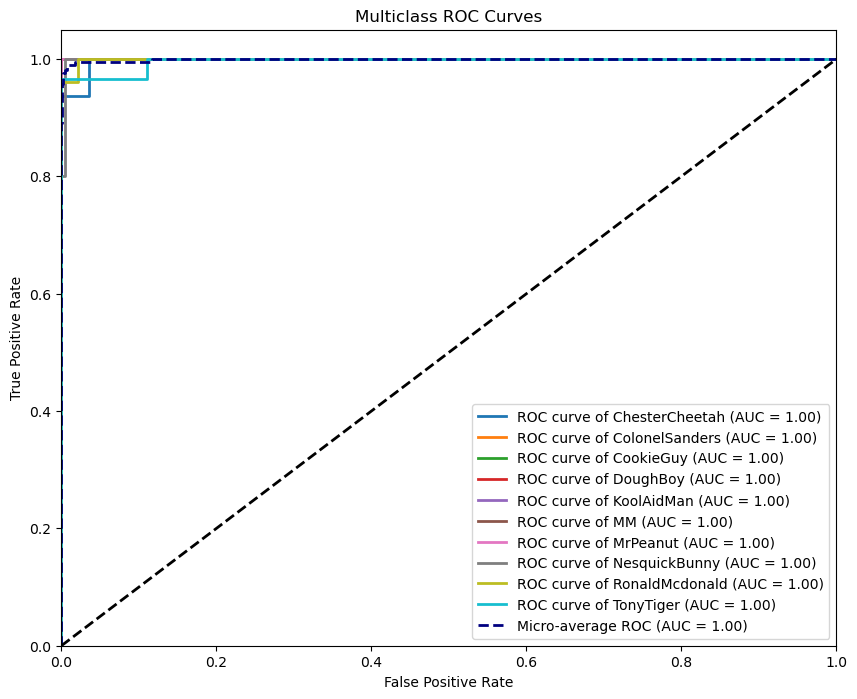

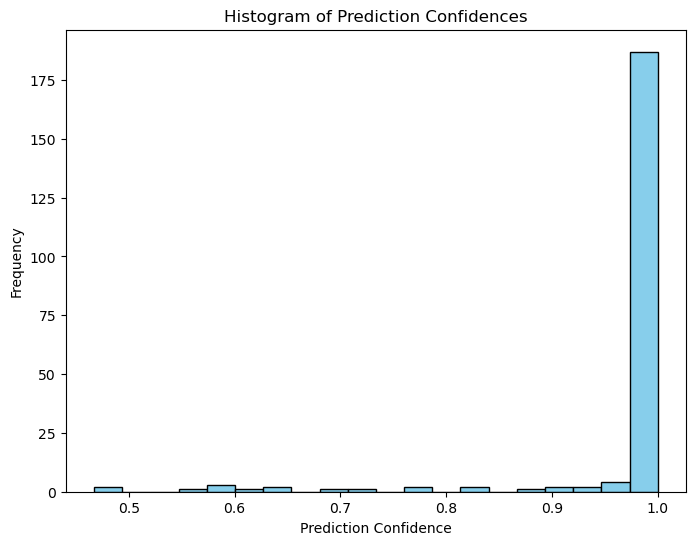

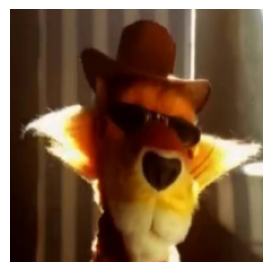

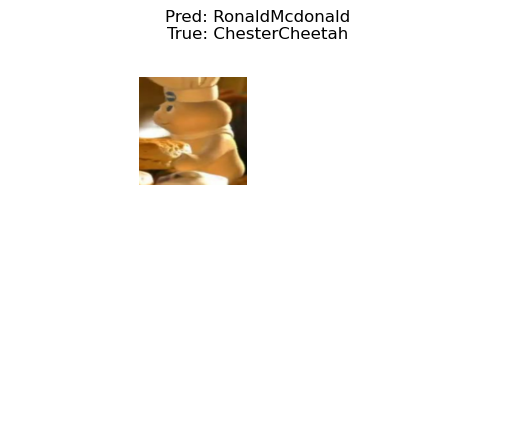

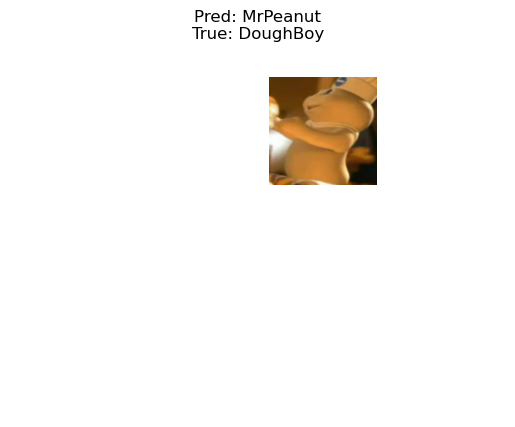

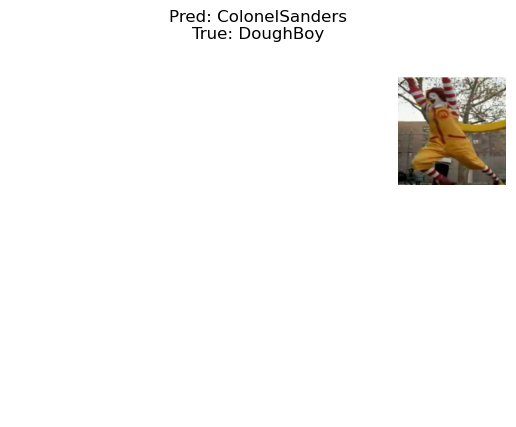

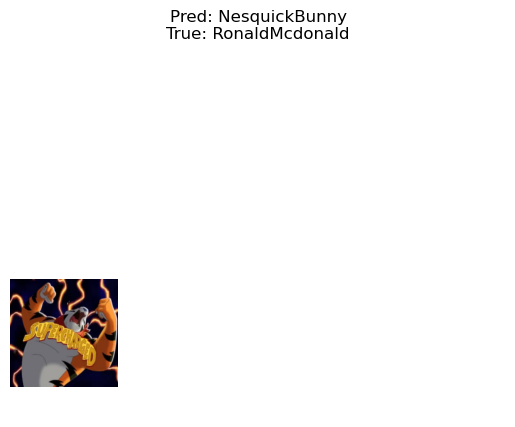

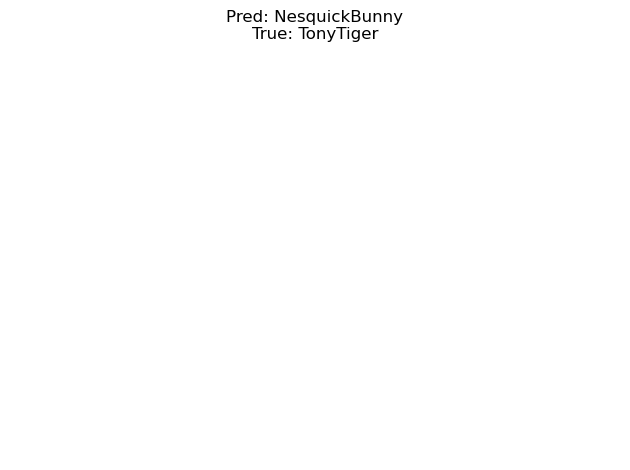

In [8]:
# 1. Plot Training vs. Validation Accuracy and Loss
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_acc_history) + 1), train_acc_history, label='Train Accuracy')
plt.plot(range(1, len(val_acc_history) + 1), val_acc_history, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_loss_history) + 1), train_loss_history, label='Train Loss')
plt.plot(range(1, len(val_loss_history) + 1), val_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

# 2. Confusion Matrix and Classification Report
cm = confusion_matrix(all_labels_np, np.array(all_preds))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:")
print(classification_report(all_labels_np, np.array(all_preds), target_names=class_names))

# 3. ROC Curves for Each Class (One-vs-Rest)
num_classes = len(class_names)
y_test_bin = label_binarize(all_labels_np, classes=list(range(num_classes)))

fpr = {}
tpr = {}
roc_auc = {}
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), all_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f'ROC curve of {class_names[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.2f})',
         color='navy', linestyle='--', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curves')
plt.legend(loc="lower right")
plt.show()

# 4. Prediction Confidence Histogram
all_confidences = [np.max(prob) for prob in all_probs]
plt.figure(figsize=(8, 6))
plt.hist(all_confidences, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Prediction Confidence')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Confidences')
plt.show()

# 5. Visualize Some Misclassified Examples
plt.figure(figsize=(15, 10))
num_images_to_show = 8  
for i in range(min(len(incorrect_images), num_images_to_show)):
    plt.subplot(2, 4, i + 1)
    imshow(incorrect_images[i])
    plt.title(f"Pred: {incorrect_predictions[i]}\nTrue: {incorrect_true_labels[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()
